In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date) as month_date,
       SUM(views_count) as total_views
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 desc
'''

df = pd.read_sql_query(query, con=engine) # выполните запрос
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Да, данные отличаются, за разные месяца. Отличия могут быть связаны с тем, что количество просмотренных постов обладает определённым сезонным трендом. Например, летом, гораздо меньше людей учиться или работает. Часть находится в отпуске или на каникулах. К сентябрю же, активность нарастает. А вот к концу года - постепенно снижается.**

**Возможно, это связано с тем, что с началом учебного года люди более замотивированы учиться, и, постепенно, поток снижается.**

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
WITH users_info AS (
SELECT sp.user_id,
       su.creation_date as registration_date,
       su.display_name,
       sp.creation_date
FROM stackoverflow.users su
LEFT JOIN stackoverflow.posts sp ON 
     sp.user_id = su.id
WHERE sp.post_type_id = 2 
)
SELECT display_name,
       COUNT(DISTINCT user_id) AS user_count
FROM users_info
WHERE DATE_TRUNC('DAY', creation_date) <= DATE_TRUNC('DAY', registration_date) + INTERVAL '1 month'
GROUP BY display_name
HAVING COUNT(*) > 100
ORDER BY display_name;
'''

df = pd.read_sql_query(query, con=engine) 
df

,display_name,user_count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Аномалия тут только одна. Для некоторых пользователей присвоено n-ое количество user_id. 
Это говорит о том, что либо, у разных пользователей, может быть одинакове display_name, либо, в базе данных неправильно собраны user_id.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
WITH
users AS (
SELECT * 
FROM stackoverflow.users 
WHERE creation_date::date BETWEEN '2008-09-01'::date and
                                  '2008-09-30'::date
), 
users_id_filter AS (
SELECT sp.user_id 
FROM stackoverflow.posts sp
INNER JOIN users u ON 
           sp.user_id=u.id
WHERE sp.creation_date::date BETWEEN '2008-12-01'::date and
                                     '2008-12-31'::date)

SELECT DATE_TRUNC('month', creation_date)::date as month,
       COUNT(*)
FROM stackoverflow.posts
WHERE EXTRACT('year' from creation_date) = 2008 AND
      user_id in (SELECT user_id FROM users_id_filter)
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY DATE_TRUNC('month', creation_date)::date DESC
'''

df = pd.read_sql_query(query, con=engine) 
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Аномалия заключается в том, что у нас представлены пользователи, которые оставили посты в августе 2008 года, хотя, мы отбирали пользователей, которые зарегестрировались в сентябре 2008 год.
У меня нет идей, почему такое возможно.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count, 
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date ASC)
FROM stackoverflow.posts
ORDER BY user_id
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query = '''
WITH user_filter AS (
SELECT user_id
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-08-01'::date and
                                  '2008-08-31'::date
GROUP BY user_id
HAVING COUNT(*) > 120),

data AS (
SELECT DISTINCT EXTRACT('day' FROM creation_date),
       user_id, 
       COUNT(*) OVER (PARTITION BY user_id, EXTRACT('day' FROM creation_date)) as total_per_day
FROM stackoverflow.posts
WHERE user_id in (SELECT user_id
                  FROM user_filter) AND
      creation_date::date BETWEEN '2008-08-01'::date and
                                  '2008-08-31'::date
)
SELECT user_id,
       AVG(total_per_day) as avg_daily
FROM data
GROUP BY user_id
ORDER BY avg_daily ASC
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query = '''
WITH user_filter AS (
SELECT *,
    COUNT(*) OVER (PARTITION BY user_id, DATE_TRUNC('day', creation_date)) as amount
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01'::date and
                                  '2008-12-07'::date
), 
interactions AS (
SELECT DISTINCT user_id, amount
FROM user_filter
)
SELECT ROUND(AVG(amount)) AS result
FROM interactions
'''
df = pd.read_sql_query(query, con=engine) 
df

,result
0,2.0


**Активность пользователей составляет 3 дня в среднем.**

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:
# напишите запрос
query = '''
SELECT user_id, creation_date,
    TO_CHAR(LAG(creation_date, 2) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month')
FROM stackoverflow.posts
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
# напишите запрос
query = '''
WITH profile AS (
    SELECT 
        user_id,
        DATE_TRUNC('month', MIN(creation_date))::date as dt
    FROM stackoverflow.posts
    GROUP BY 1
),
sessions AS
  (SELECT p.user_id,
          DATE_TRUNC('month', creation_date)::date AS session_dt
   FROM stackoverflow.posts e
   JOIN profile p ON p.user_id = e.user_id
   GROUP BY 1,
            2),
cohort_users_cnt AS
  (SELECT dt,
          COUNT(user_id) AS cohort_users_cnt
   FROM profile
   GROUP BY 1)

SELECT p.dt AS cohort_dt,
       s.session_dt,
       COUNT(p.user_id) AS users_cnt,
       c.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / c.cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
JOIN cohort_users_cnt c ON p.dt = c.dt
GROUP BY 1,
         2,
         4;
'''

df = pd.read_sql_query(query, con=engine) 
df

,cohort_dt,session_dt,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

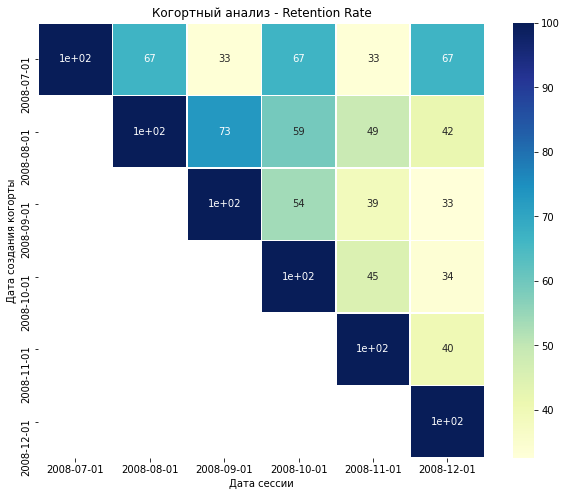

In [14]:
# Pivot the DataFrame to get retention_rate values as a matrix
cohort_matrix = df.pivot(index='cohort_dt', columns='session_dt', values='retention_rate')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cohort_matrix, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Когортный анализ - Retention Rate')
plt.xlabel('Дата сессии')
plt.ylabel('Дата создания когорты')
plt.show()

аномалии заключаются в отсутсвие стабильного изменения Retention Rate.
Видно, что у пользователей со временм снижается коеф. возврата.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [15]:
# напишите запрос
query = '''
WITH t1 AS (
SELECT EXTRACT('month' FROM creation_date) as creation_month,
       COUNT(*) as posts_count
FROM stackoverflow.posts
WHERE creation_date BETWEEN '01.09.2008'::date AND 
                            '01.01.2009'::date
GROUP BY 1)
SELECT *, 
    ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100, 2) 
FROM t1
'''

df = pd.read_sql_query(query, con=engine) 
df

,creation_month,posts_count,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

<Figure size 720x1440 with 0 Axes>

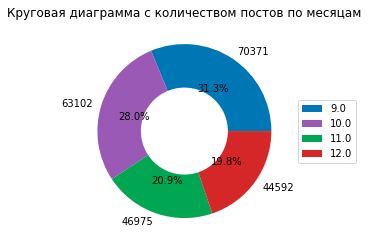

In [16]:
colors = ['#0077b5', '#9b59b6', '#00a651', '#d62728']

plt.figure(figsize=(10, 20))
fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(df.posts_count, labels=df.posts_count, colors=colors, wedgeprops={'linewidth': 0}, autopct='%1.1f%%')

centre_circle = plt.Circle((0, 0), 0.5, color='white', fc='white', linewidth=0)

ax.add_artist(centre_circle)

for text in texts:
    text.set_color('black')  # Цвет текста будет белым

for autotext in autotexts:
    autotext.set_color('black')  # Цвет процентных значений тоже будет белым

ax.set(aspect='equal')

plt.title('Круговая диаграмма с количеством постов по месяцам')

ax.legend(df.creation_month, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
# напишите запрос
query = '''
WITH t1 AS (
SELECT user_id,
       COUNT(*) as total_amount
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY total_amount DESC
LIMIT 1), 
t2 AS (
SELECT creation_date,
       EXTRACT('week' FROM creation_date) AS week_creation
FROM stackoverflow.posts
WHERE user_id in (SELECT user_id FROM t1) AND
      creation_date BETWEEN '2008-10-01'::date AND
                            '2008-11-01'::date
)
SELECT DISTINCT week_creation, 
       LAST_VALUE(creation_date) OVER (PARTITION BY week_creation ORDER BY week_creation ASC) as creation_date
FROM t2
ORDER BY week_creation
'''

df = pd.read_sql_query(query, con=engine) 
df

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
